In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold


In [4]:
# Load datasets

matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/featureMatrix/3_matrix_comb.csv', index_col=0)
X = matrix.drop(columns=['BDSPPatientID','NoteDate', 'NoteTitle', 'text', 'annot', 'hospital'])

y_data = matrix[['BDSPPatientID', 'annot', 'hospital']]
y = y_data['annot']

In [5]:
X.head()

,ICD,r pstosis,fasciculation,cta,ischemic stroke,hydrocephalus,scattered,skull,acom,hob>30 degrees,...,lethargic,subarachnoid,paraphasic errors,xanthochromia,rebleed,neuro,hemorrhage,nontraumatic,artery,facial droop
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: annot, dtype: int64

In [8]:
# Separate data by hospital
## SWITCH TO CHANGE TRAINING AND TESTING SET ##
train_hospital = 'MGB'
test_hospital = 'BIDMC'

X_train = X[y_data['hospital'] == train_hospital]
y_train = y[y_data['hospital'] == train_hospital]

X_test = X[y_data['hospital'] == test_hospital]
y_test = y[y_data['hospital'] == test_hospital]

all_predictions = []
all_true_labels = []
all_row_numbers = []

# Outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}

model = LogisticRegression(
    penalty='elasticnet',
    class_weight=None, random_state=2023,
    solver='saga', max_iter=10000
)

search_spaces = {
    'C': (1e-2, 1e+2, 'log-uniform'),
    'l1_ratio': (0.01, 0.99),
}
model_cv = BayesSearchCV(model,
                         search_spaces,
                         n_iter=50, scoring='roc_auc', n_jobs=15,
                         cv=5, random_state=2023)
model_cv.fit(X_train, y_train)

# Find the best hyperparameters and append them
best_hparams = model_cv.best_params_
best_C = best_hparams['C']
best_l1_ratio = best_hparams['l1_ratio']
final_Cs.append(best_C)
final_l1.append(best_l1_ratio)

model = model_cv.best_estimator_

ytr_pred = model.predict_proba(X_train)[:, 1]
yte_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, cutoffs = roc_curve(y_test, yte_pred)
best_cutoff = cutoffs[np.argmax(tpr - fpr)]
yte_pred_bin = (yte_pred > best_cutoff).astype(int)
auc_cv.append(roc_auc_score(y_test, yte_pred))
f1_cv.append(f1_score(y_test, yte_pred_bin))
cf_cv.append(confusion_matrix(y_test, yte_pred_bin))
predictions.append(yte_pred_bin)

# Store the predictions and true labels
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(y_data[y_data['hospital'] == test_hospital]['BDSPPatientID'])

# Save info for the plots
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
pr_curves.append((recall, precision, auc(recall, precision)))
auc_pr_loop = auc(recall, precision)
auc_pr.append(auc_pr_loop)

# Extract feature importances (coefficients)
feature_importances = model.coef_[0]
for feature, importance in zip(X.columns, feature_importances):
    feature_importances_dict[feature].append(importance)

print("Feature importances:")
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)



Feature importances:
           Feature  Importance
108            sah    1.321163
119   subarachnoid    0.771018
87       vasospasm    0.557165
85        aneurysm    0.545951
5    hydrocephalus    0.428740
..             ...         ...
96            fall   -0.178995
75           vomit   -0.190995
74          strike   -0.328956
39             sdh   -0.382930
44          trauma   -0.594592

[128 rows x 2 columns]


In [9]:
print(auc_cv)
print(auc_pr)

#train mgh
#0.9532563025210085
#0.7652891776522541

[0.9226392040495722]
[0.8793247381319783]


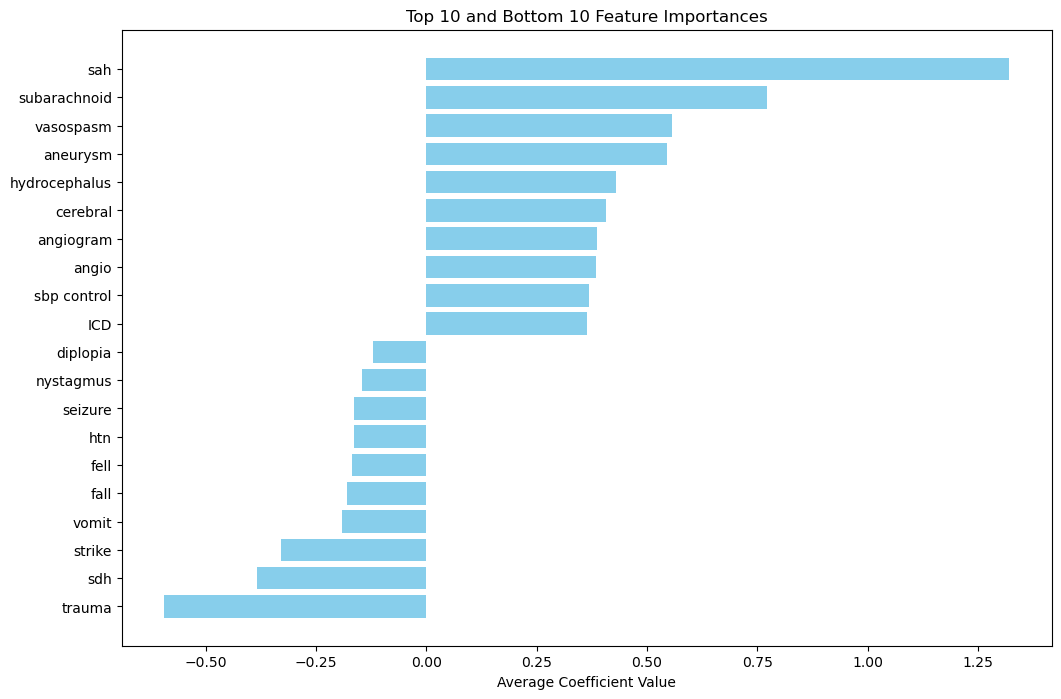

<Figure size 640x480 with 0 Axes>

In [13]:
# Save the DataFrame to a CSV file
feature_importance_df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/feat_importances.csv', index=False)

# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Top 10 and Bottom 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/feat_importances.png')

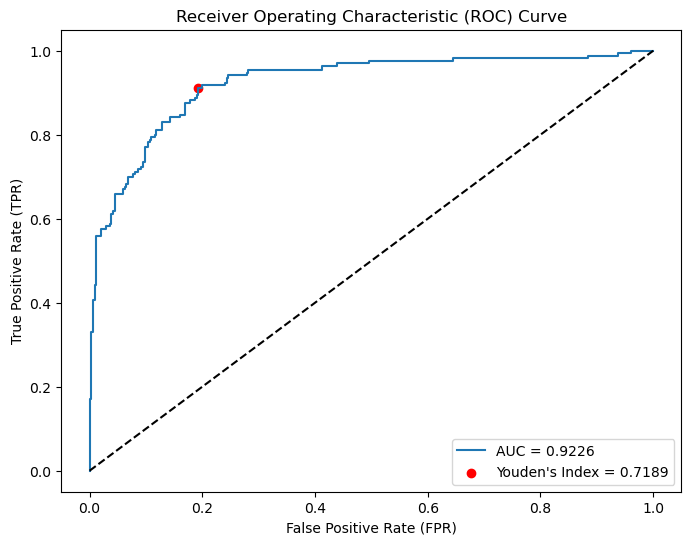

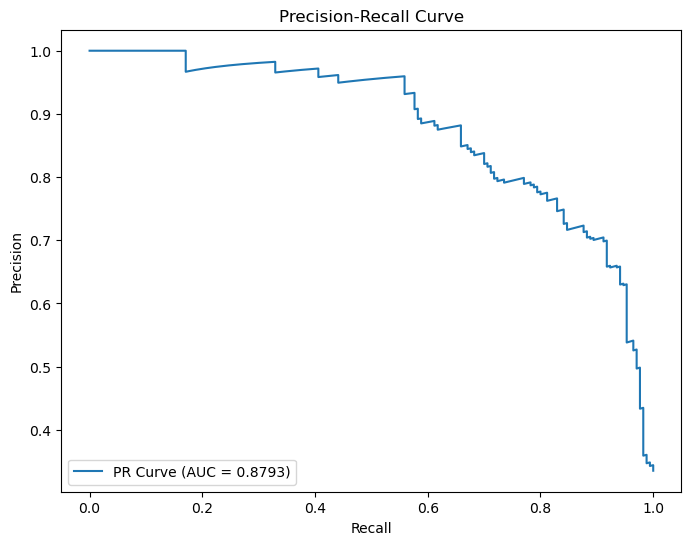

0.9226392040495722
[0.8793247381319783]
0.7917737789203085


In [15]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_cv[0]))
youden = np.max(tpr-fpr)
plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/AUC_iter.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/PR_iter.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/LR_iter_pred.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df_pred = pd.concat([df1]).reset_index()
df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/LR_iter.csv')

# Print final Data
print(auc_final)
print(auc_pr)
print(f1_final)

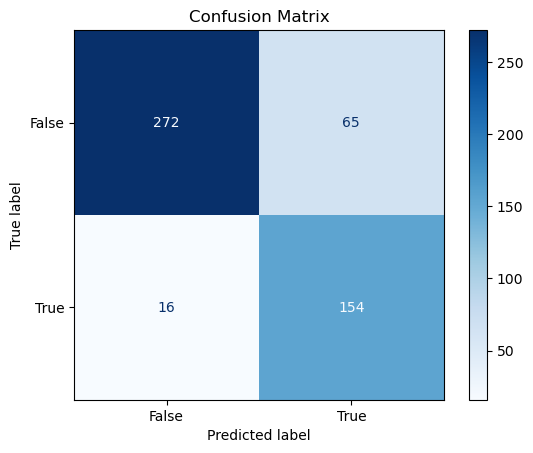

[[272  65]
 [ 16 154]]


In [31]:
# Create the confusion matrix
cf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[False, True])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/trainMGB_testBIDMC/cf_matrix.png')
plt.show()

# Print the confusion matrix
print(cf_matrix)